In [3]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [4]:
import scipy as sp
from scipy import *
from scipy import optimize

In [5]:
import numpy as np
from numpy import matrix as mat
from numpy import dot
from math import sqrt

In [74]:
from wavefunction import *
from wavefunction.wavefunction1d import *
from numpy.polynomial import hermite as he
from scipy.special import factorial

## Problem parameters

In [77]:
h = 1
h_ = h/(2*pi)
e = 1.602e-19
cf = 1          # if cf = h_, use units where h_ = 1

m_e = 1          # oscillator mass
omega = 1 * pi  # oscillator frequency in GHz
x0 = 0          # shift in oscillator potiential minimum

args = {'w': omega, 'm': mm, 'x0': x0}

k = -h_ ** 2 / (2 * mm)

x_min = -pi
x_max =  pi
N_basis = 54
N_grid = 100
dx = (x_max - x_min)/(N_grid-1)

In [64]:
def plot(x ,y,opt = None, r =( x_min, x_max) ):
    fig, ax = subplots(figsize=(12,8))
    Y = y
    if opt == None :    
        ax.plot(x,Y.real)
    elif opt == 1:
        ax.plot(Y.real)
    ax.set_xlim(r)
    ax.set_xlabel(r'$x$', fontsize=18)
    #axes[n].set_ylabel(r'$\Psi_n(x)$', fontsize=18);
    fig.tight_layout();


## Harmonic potential

In [65]:
def U_ho(x, args):
    """
    Harmonic oscillator potential
    """
    
    omega = args['w']
    m     = args['m']
    x0    = args['x0']
    
    u = 1/2.0 * m * (omega ** 2) * ((x - x0) ** 2)

    return u

## Find the minimum point for the potential

In [66]:
x = linspace(x_min, x_max, N)
U = U_ho(x, args);
x_opt_min = optimize.fmin(U_ho, [0.0], (args,))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 6


## Plot the potential

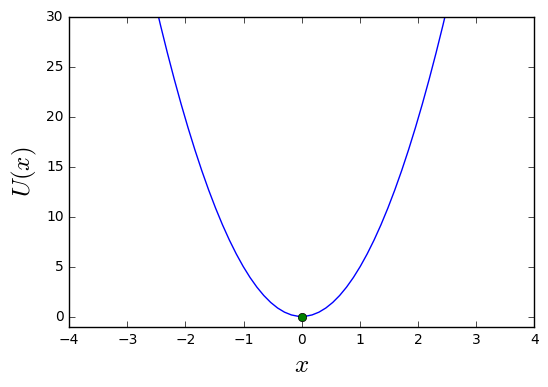

In [67]:
fig, ax = subplots()

ax.plot(x, U)
ax.plot(x_opt_min, U_ho(x_opt_min, args), 'o')

ax.set_ylim(-1, 30)
ax.set_xlabel(r'$x$', fontsize=18)
ax.set_ylabel(r'$U(x)$', fontsize=18);

## Creation and annihilation operators

In [68]:
def create_a(N_basis):
    a = mat([[0. for x in range(N_basis)] for x in range(N_basis)])
    for n in range(N_basis-1):
        a[n, n+1] = sqrt(n+1)
    return a
def create_ad(N_basis):
    ad = mat([[0. for x in range(N_basis)] for x in range(N_basis)])
    for n in range(N_basis-1):
        ad[n+1, n] = sqrt(n+1)
    return ad

## Delta function matrix 

In [69]:
def create_delta(N_basis):
    delta = mat([[0. for x in range(N_basis)] for x in range(N_basis)])
    for n in range(N_basis):
        delta[n, n] = 1.
    return delta

delta = create_delta(N_basis)

## Hermite basis set 

In [70]:
def gs(x,omega = omega,h_= h_, m_e = m_e):
    """ compute ground state
    Args:
        x : float 
            position
        n : intiger
            plynimial order
        omega : float
            frequency
        h_ : float
            hbar
        m_e : float
            electron mass
    """
    gs = sqrt(sqrt((m_e * omega)/(pi * h_))) * exp(- (m_e * omega * x**2)/(2 * h_))
    return gs

In [71]:
def H_ren(x,n ,omega = omega,h_= h_, m_e = m_e):
    """
    Compute the Hermite polynomials
    Args:
        x : float 
            position
        n : intiger
            plynimial order
        omega : float
            frequency
        h_ : float
            hbar
        m_e : float
            electron mass
    """
    index_list = [0 for i in arange(n)]
    index_list.append(1)
    return he.hermval(sqrt((m_e * omega)/ h_) * x, index_list)  

In [72]:
def create_basis(N_grid = N_grid, N_basis= N_basis, r= (x_min, x_max)):
    """
    Creates basis set
    Args:
        x : float 
            position
        n : intiger
            plynimial order
        omega : float
            frequency
        h_ : float
            hbar
        m_e : float
            electron mass
    Return:
        basis_ste : matrix (N_basis x N_grid)
    """
    basis_set = zeros((N_basis, N_grid)).astype(np.complex)
    dx = (x_max - x_min)/(N_grid-1)
    for n in arange(N_basis):
        basis_set[n] = [gs(dx * i +x_min) * H_ren(dx * i +x_min, n) for i in arange(N_grid)] 
        basis_set[n] =  basis_set[n]/sqrt(2**n * factorial(n, exact = False))#*sqrt(np.dot(np.conj(basis_set[n]),basis_set[n])))
    return basis_set

In [75]:
basis_set =create_basis();

## projection operator

In [91]:
def project_op(i,j, basis_set = basis_set):
    """
    It takes "i"th and "j"th basis in the position representation and returns the projection |i><j| 
    in the position space.
    Args:
        i,j : int 
            index
         basis_set : matrix (N_basis x N_grid)
    Return:
        proj_ij : matrix (N_grid x N_grid)
    """
    proj_ij = zeros(( shape(basis_set[0])[0], shape(basis_set[0])[0])).astype(np.complex)
    b_i = basis_set[i]
    b_j = basis_set[j]
    x_grid = arange(shape(basis_set[0])[0])
    for l in x_grid:
        for k in x_grid:
            proj_ij[l,k] = b_i[l] * conj(b_j[k])
#        print(proj_ij[l,k])
    return proj_ij

## Testing ortonormality 

In [79]:
overlap_matrix = zeros((N_basis, N_basis)).astype(np.complex)
for i in arange(N_basis):
    overlap_matrix[i] = [dx *np.dot(np.conj(basis_set[i])\
              ,basis_set[j]) for j in arange(N_basis)] 

overlap_matrix

array([[  1.00000000e+00+0.j,   3.12234693e-16+0.j,  -6.73792778e-17+0.j,
        ...,  -9.01913470e-16+0.j,  -1.18835123e-15+0.j,
          7.60989490e-16+0.j],
       [  3.12234693e-16+0.j,   1.00000000e+00+0.j,  -2.73040211e-17+0.j,
        ...,  -3.57294843e-16+0.j,  -5.35511123e-16+0.j,
          2.66275167e-16+0.j],
       [ -6.73792778e-17+0.j,  -2.73040211e-17+0.j,   1.00000000e+00+0.j,
        ...,  -1.84610413e-15+0.j,   6.60329996e-16+0.j,
          2.09976730e-15+0.j],
       ..., 
       [ -9.01913470e-16+0.j,  -3.57294843e-16+0.j,  -1.84610413e-15+0.j,
        ...,   1.00018839e+00+0.j,   4.10088781e-15+0.j,
         -4.51062526e-04+0.j],
       [ -1.18835123e-15+0.j,  -5.35511123e-16+0.j,   6.60329996e-16+0.j,
        ...,   4.10088781e-15+0.j,   9.99547204e-01+0.j,
          4.79141531e-16+0.j],
       [  7.60989490e-16+0.j,   2.66275167e-16+0.j,   2.09976730e-15+0.j,
        ...,  -4.51062526e-04+0.j,   4.79141531e-16+0.j,
          1.00103910e+00+0.j]])

In [34]:
a_op = create_a(N_basis)
ad_op = create_ad (N_basis)

## Kintetic enery operator in the harmic oscillator basis using ladder operators

In [36]:
t_op = - (dot(ad_op , ad_op) + dot(a_op , a_op) - dot(ad_op , a_op) - dot(a_op , ad_op) )*(h_ * omega )/2

## Harmonic potential in the harmic oscillator basis using ladder operators

In [88]:
u_basis = 1/4.0 *h_ * omega *  (dot(ad_op , ad_op) + dot(a_op , a_op) + dot(ad_op , a_op) + dot(a_op , ad_op) )

## Initializing functions for matrices

In [37]:
def create_g(N_basis):
    g = mat([[0. for i in arange(N_basis)] for i in arange(N_basis)])
    return g

In [38]:
def init_potential(density):
    potential = mat([[0. for i in arange(N_basis)] for i in arange(N_basis)])
    return potential
def init_density(time = 0):
    density = mat([[5 for i in arange(N_basis)] for i in arange(N_basis)])
    return density

In [83]:
gf_w = create_g(N_basis)
hamiltonian = t_op + u_basis
density = init_density()
v_tilde = init_potential(density)

In [84]:
green_f = dict({})
af = {}

In [89]:
for omega in np.arange(0,1,0.1):
    gf_w = dot(linalg.inv(np.add( omega * delta  - hamiltonian , - v_tilde)),delta)
    green_f.update({omega:gf_w})

In [90]:
green_f

{0.0: matrix([[ -2.79479060e+00,   0.00000000e+00,  -2.71791903e-01, ...,
            0.00000000e+00,  -4.49585875e-21,   0.00000000e+00],
         [  0.00000000e+00,  -9.18955855e-01,   0.00000000e+00, ...,
           -1.32211732e-20,   0.00000000e+00,  -4.36528373e-21],
         [ -2.71791903e-01,   0.00000000e+00,  -5.76557693e-01, ...,
            0.00000000e+00,  -9.53715664e-21,   0.00000000e+00],
         ..., 
         [  0.00000000e+00,  -1.32211732e-20,   0.00000000e+00, ...,
           -2.82857447e-02,   0.00000000e+00,  -9.33920912e-03],
         [ -4.49585875e-21,   0.00000000e+00,  -9.53715664e-21, ...,
            0.00000000e+00,  -2.61446630e-02,   0.00000000e+00],
         [  0.00000000e+00,  -4.36528373e-21,   0.00000000e+00, ...,
           -9.33920912e-03,   0.00000000e+00,  -5.33980267e-02]]),
 0.10000000000000001: matrix([[ -3.89425964e+00,   0.00000000e+00,  -4.01192030e-01, ...,
            0.00000000e+00,  -8.04360387e-21,   0.00000000e+00],
         [  0.00000